# AI Job Salary Prediction - Smart Analysis

## 1. Import Libraries

In [12]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

#%matplotlib inline

## 2. Load and Inspect Data

In [14]:
df = pd.read_csv('ai_job_dataset.csv')
print(f"Shape of dataset: {df.shape}")
df.head()

Shape of dataset: (15000, 19)


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [16]:
# Check for missing values
df.isnull().sum()

job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

## 3. Exploratory Data Analysis (EDA)
### 3.1 Target Variable Distribution (Salary)

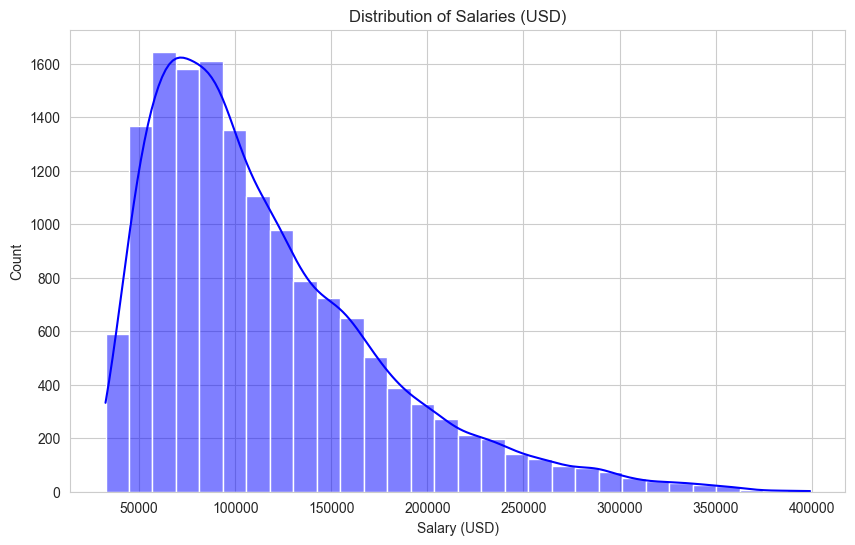

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_usd'], kde=True, bins=30, color='blue')
plt.title('Distribution of Salaries (USD)')
plt.xlabel('Salary (USD)')
plt.show()

### 3.2 Categorical Feature Analysis

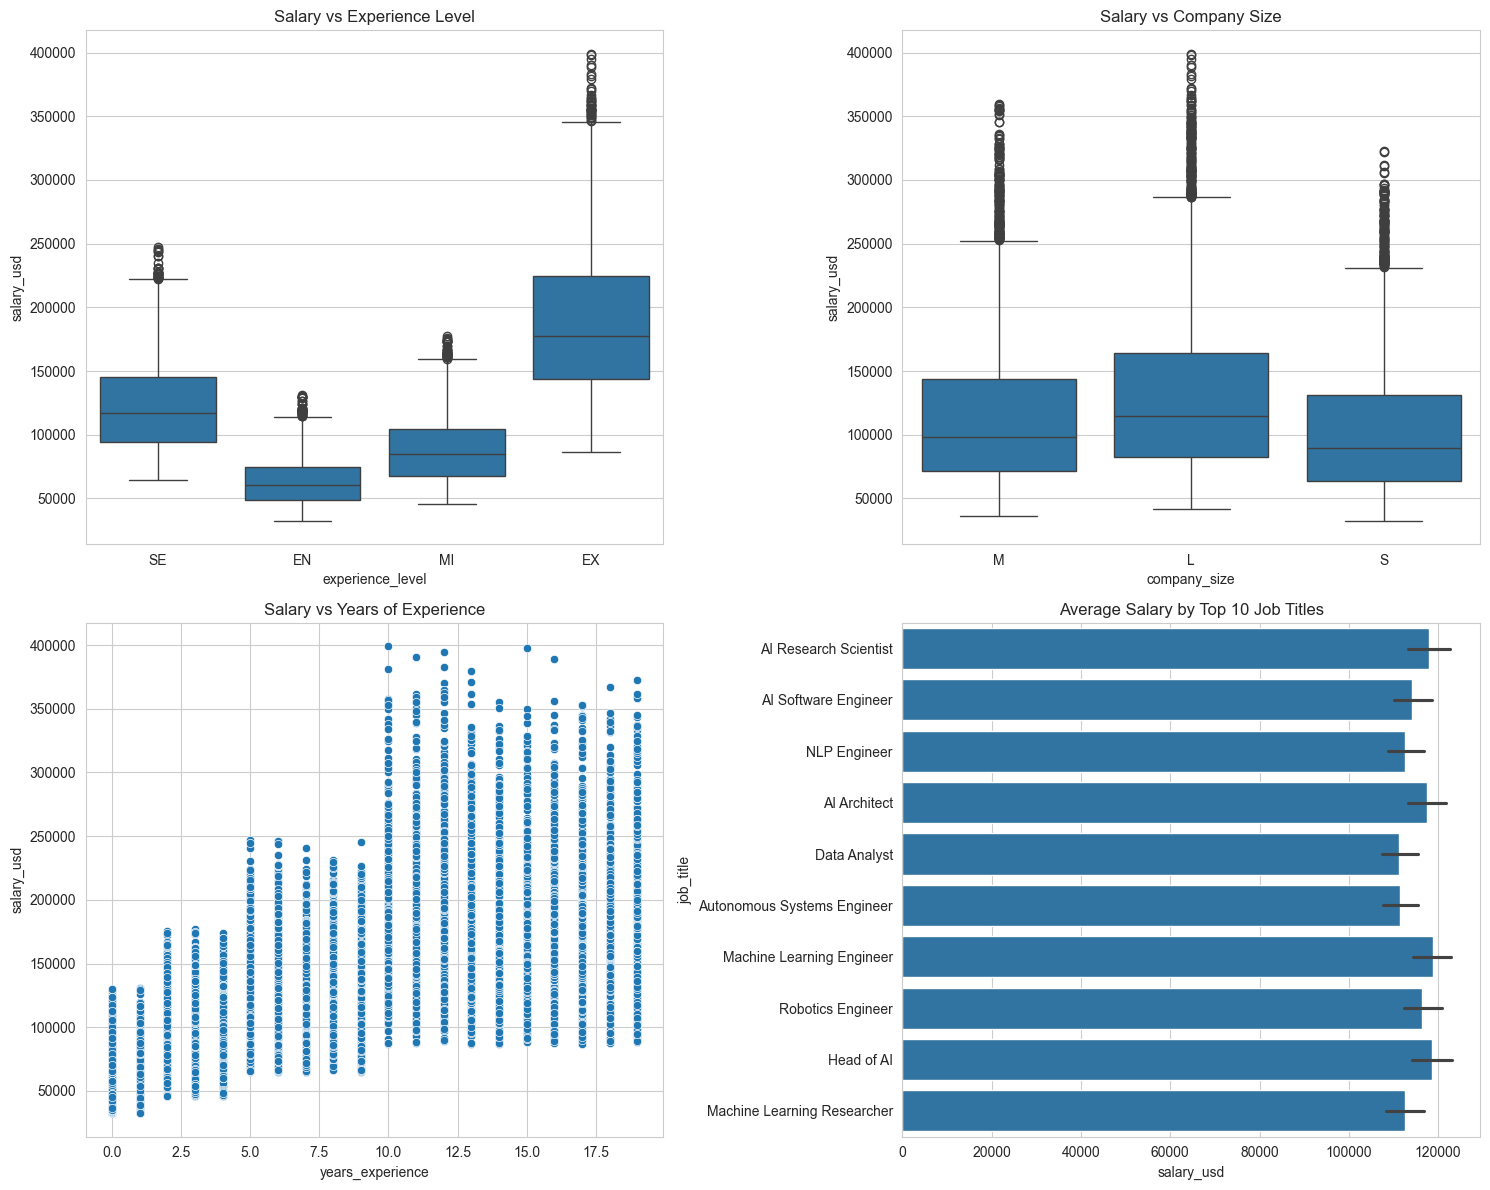

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.boxplot(x='experience_level', y='salary_usd', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Salary vs Experience Level')

sns.boxplot(x='company_size', y='salary_usd', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Salary vs Company Size')

sns.scatterplot(x='years_experience', y='salary_usd', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Salary vs Years of Experience')

# Top 10 Job Titles
top_jobs = df['job_title'].value_counts().nlargest(10).index
sns.barplot(x='salary_usd', y='job_title', data=df[df['job_title'].isin(top_jobs)], ax=axes[1, 1], estimator=np.mean)
axes[1, 1].set_title('Average Salary by Top 10 Job Titles')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [19]:
# Drop irrelevant columns
drop_cols = ['job_id', 'salary_currency', 'posting_date', 'application_deadline', 'job_description_length']
df_clean = df.drop(columns=drop_cols, errors='ignore')

# Encode Categorical Variables
categorical_cols = df_clean.select_dtypes(include=['object']).columns
# Keep track of label encoders if needed later
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

df_clean.head()

,job_title,salary_usd,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,benefits_score,company_name
0,3,90376,3,0,3,1,3,50,12938,1,9,0,5.9,14
1,4,61895,0,0,2,1,9,100,1779,2,1,9,5.2,15
2,5,152626,2,1,17,0,15,0,5167,0,2,2,9.4,3
3,16,80215,3,1,8,1,8,50,11651,3,7,1,8.6,9
4,1,54624,0,3,6,2,14,100,6607,2,0,9,6.6,1


## 5. Model Development

In [20]:
X = df_clean.drop('salary_usd', axis=1)
y = df_clean['salary_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Train and Compare Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"Model: {name}")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    print("-"*30)

Model: Linear Regression
MAE: $27363.90
RMSE: $37331.72
R2 Score: 0.6179
------------------------------
Model: Random Forest
MAE: $15254.73
RMSE: $21373.95
R2 Score: 0.8747
------------------------------


## 6. Model Evaluation & Selection
The **Random Forest Regressor** outperformed the Linear model regarding R2 Score and lower errors. We select it as our final model.

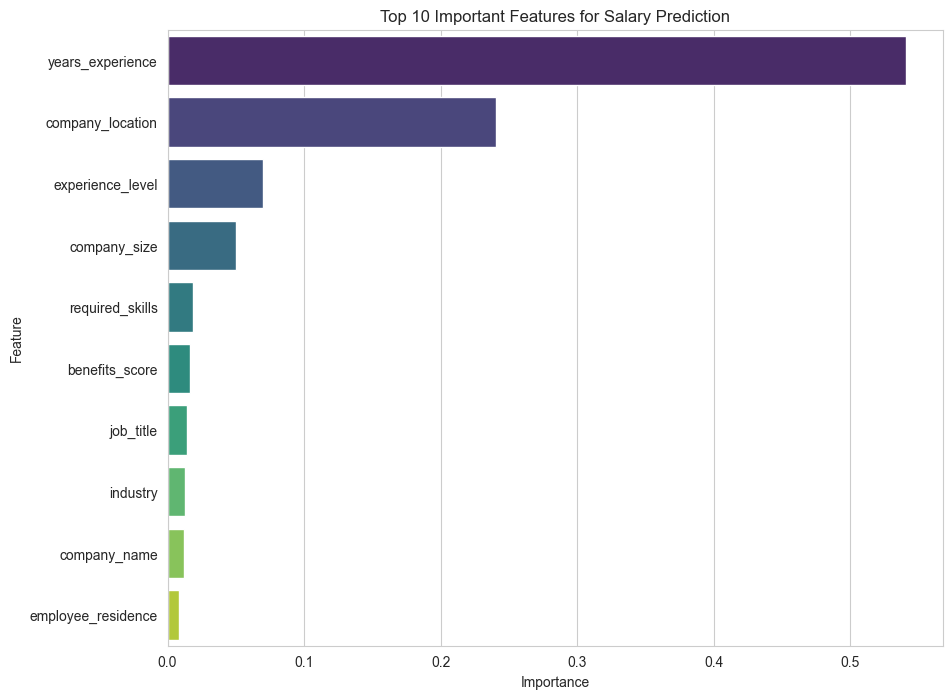

In [22]:
best_model = models["Random Forest"]

# Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')
plt.title('Top 10 Important Features for Salary Prediction')
plt.show()

In [24]:
# Save the model
joblib.dump(best_model, 'salary_predictor_model.pkl')
print("Model saved as 'salary_predictor_model.pkl'")

Model saved as 'salary_predictor_model.pkl'
